<a href="https://colab.research.google.com/github/visiont3lab/deep-learning-course/blob/main/colab/ObjectDetectionUpdate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single Object detection project

## References
* [bounding box regression pyimage search](https://www.pyimagesearch.com/2020/10/05/object-detection-bounding-box-regression-with-keras-tensorflow-and-deep-learning/)
* [Deep learning course](https://github.com/visiont3lab/deep-learning-course)
* [Pytorch computer vision cookbook](https://github.com/PacktPublishing/PyTorch-Computer-Vision-Cookbook)
* [How to get file from google drive](https://silicondales.com/tutorials/g-suite/how-to-wget-files-from-google-drive/)
* [Computer vision annotation tool (CVAT)](https://cvat.org/) [openvino toolkit cvat Github](https://github.com/openvinotoolkit/cvat)

## Step 1) Use CVAT data annotation tool to  Collect Data

* [Annotation CVAT  Github](https://github.com/openvinotoolkit/cvat)

1. Accedere al sito [Annotation CVAT  Online](https://cvat.org/)
2. Creare un account
3. Eseguire login
4. Creare un nuovo progetto (face-custo-keypoints)
5. Selezionare Constructor e configurare le labels ( eye-point-left, eye-point-right, face-rect, nose)
6. Creare e Aprire il progetto
7. Creare le label
8. Esportare le label come **CVAT for images 1.1**

In [ ]:
# wget a file from google drive -- https://silicondales.com/tutorials/g-suite/how-to-wget-files-from-google-drive/
# Dataset link: https://drive.google.com/file/d/12ob_5b-A0afVNjhPkmlNPgKIaM5tnA3m/view
# Use the below to wget in large files (over 100MB) from Google Drive. Added by Robin Scott of SiliconDales.com. See full instructions at https://silicondales.com/tutorials/g-suite/how-to-wget-files-from-google-drive/
# wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=FILE_ID' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=FILE_ID" -O FILE_NAME && rm -rf /tmp/cookies.txt

# --> Dataset Manuel 
#!rm -rf dataset
#!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=12ob_5b-A0afVNjhPkmlNPgKIaM5tnA3m' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=12ob_5b-A0afVNjhPkmlNPgKIaM5tnA3m" -O dataset.zip && rm -rf /tmp/cookies.txt
#!unzip dataset.zip 
#!rm dataset.zip

# --> Dataset easter eggs
#!rm -rf dataset
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1dkyOsHFkIepfSaL9e8HueqwVeVLU12l_' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1dkyOsHFkIepfSaL9e8HueqwVeVLU12l_" -O dataset.zip && rm -rf /tmp/cookies.txt
!unzip dataset.zip
!rm dataset.zip 
!mv dataset-easter-egg dataset

In [3]:
import xml.etree.ElementTree as ET
import pandas as pd 

# CVAT for images 1.1
# Labels --> filename xc,yc,w,h --> coordinate 0-1 --> coco dataset

mydict = {"filename": [],  "xtl": [] ,"ytl": [],"xbr": [],"ybr": []}
xml_file = "dataset/annotations.xml"
tree = ET.parse(xml_file)
root = tree.getroot()
for image in root:
    if image.tag=="image":
        #print(image.tag, image.attrib)
        iW = float(image.attrib["width"])
        iH = float(image.attrib["height"])
        for box in image:
            #print(box.attrib)
            xtl = float(box.attrib["xtl"]) / iW
            ytl = float(box.attrib["ytl"]) / iH
            xbr = float(box.attrib["xbr"]) / iW
            ybr = float(box.attrib["ybr"]) / iH
            
            mydict["filename"].append(image.attrib["name"])
            mydict["xtl"].append(xtl)
            mydict["ytl"].append(ytl)
            mydict["xbr"].append(xbr)
            mydict["ybr"].append(ybr)
            
df = pd.DataFrame(mydict)
df.to_csv("dataset/annotations.csv", index=None)

## Step 2) Include library Library and Utils

In [4]:
import os
from PIL import Image,ImageFont,ImageDraw
import numpy as np

from torch.utils.data import Dataset
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import copy

## Step 3) Understading data augmentation: Data Augmentation Transformations

In [5]:
import torchvision.transforms.functional as TF
import random 

def resize_img_label(image,label=(0.,0.),target_size=(256,256)):
    w_orig,h_orig = image.size   
    w_target,h_target = target_size
    cx, cy= label
    
    # resize image and label
    image_new = TF.resize(image,target_size)
    label_new= cx/w_orig*w_target, cy/h_orig*h_target
    
    return image_new,label_new

def random_hflip(image,label):
    w,h=image.size
    x,y=label        

    image = TF.hflip(image)
    label = w-x, y
    return image,label

def random_vflip(image,label):
    w,h=image.size
    x,y=label
    image = TF.vflip(image)
    label = x, h-y
    return image, label

def random_shift(image,label,max_translate=(0.2,0.2)):
    w,h=image.size
    max_t_w, max_t_h=max_translate
    cx, cy=label

    # translate coeficinet, random [-1,1]
    trans_coef=np.random.rand()*2-1
    w_t = int(trans_coef*max_t_w*w)
    h_t = int(trans_coef*max_t_h*h)

    image=TF.affine(image,translate=(w_t, h_t),shear=0,angle=0,scale=1)
    label = cx+w_t, cy+h_t
        
    return image,label

def transformer(image, label, params):
    image,label=resize_img_label(image,label,params["target_size"])

    if random.random() < params["p_hflip"]:
        image,label=random_hflip(image,label)
        
    if random.random() < params["p_vflip"]:            
        image,label=random_vflip(image,label)
        
    if random.random() < params["p_shift"]:                            
        image,label=random_shift(image,label, params["max_translate"])

    if random.random() < params["p_brightness"]:
        brightness_factor=1+(np.random.rand()*2-1)*params["brightness_factor"]
        image=TF.adjust_brightness(image,brightness_factor)

    if random.random() < params["p_contrast"]:
        contrast_factor=1+(np.random.rand()*2-1)*params["contrast_factor"]
        image=TF.adjust_contrast(image,contrast_factor)

    if random.random() < params["p_gamma"]:
        gamma=1+(np.random.rand()*2-1)*params["gamma"]
        image=TF.adjust_gamma(image,gamma)

    if params["scale_label"]:
        label=scale_label(label,params["target_size"])
        
    image=TF.to_tensor(image)
    return image, label

def scale_label(a,b):
    div = [ai/bi for ai,bi in zip(a,b)]
    return div

## Step 4) Dataset Preparation ( Dataset, DataLoader, Data Augmentation ) 

In [ ]:
!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf

In [9]:
def rescale_bbox(bb,W,H):
    # rescale coordiante 0-1 to W-H (original size)
    x,y,w,h = bb
    return [x*W,y*H,w*W,h*H]

def get_img_bbox(imageTensor,labelTensor):
    fnt = ImageFont.truetype('thsarabunnew-webfont.ttf',12)
    imagePil = transforms.ToPILImage()(imageTensor)
    bbox = labelTensor.tolist()
    W,H = imagePil.size
    draw = ImageDraw.Draw(imagePil)
    name = "label"
    if len(bbox)==2:
        xc,yc = bbox
        xc = xc*W
        yc = yc*H
        w = 20
        h = 20
    else:
        bbox = rescale_bbox(bbox,W,H)
        xc,yc,w,h = bbox
    draw.rectangle( [(xc-w/2,yc-h/2), (xc+w/2,yc+h/2)], outline=(255,0,0),width=1)
    draw.text( (xc-w/2,yc-h/2), name, font=fnt, fill=(255,0,0,0) )
    return imagePil

def compare_img_bbox(imageTensor,labelTensor,labelEstimatedTensor):
    fnt = ImageFont.truetype('thsarabunnew-webfont.ttf',12)
    imagePil = transforms.ToPILImage()(imageTensor)
    for l,c in zip([labelTensor,labelEstimatedTensor],[(255,0,0),(0,255,0)]):
        bbox = l.tolist()
        W,H = imagePil.size
        if len(bbox)==2:
            xc,yc = bbox
            xc = xc*W
            yc = yc*H
            w = 20
            h = 20
        else:
            bbox = rescale_bbox(bbox,W,H)
            xc,yc,w,h = bbox
        draw = ImageDraw.Draw(imagePil)
        draw.rectangle( [(xc-w/2,yc-h/2), (xc+w/2,yc+h/2)], outline=tuple(c),width=1)
    return imagePil

def get_transforms(target_size):
    train_tf = transforms.Compose([
            transforms.Resize(target_size),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ])
    test_tf = transforms.Compose([
            transforms.Resize(target_size),
            transforms.ToTensor(),
    ])
    return train_tf, test_tf

class CustomDataset(Dataset):

    def __init__(self, folder_images_path, folder_labels_path,transform=None,params=None):
        self.df_labels = pd.read_csv(folder_labels_path) # dataframe containing labels
        self.path2images = [ os.path.join(folder_images_path,name) for name in os.listdir(folder_images_path)]
        self.transform = transform  
        self.params = params
    
    def __getitem__(self, index):
        path2img = self.path2images[index]
        # get filename 
        filename = os.path.basename(path2img)
        # get label associated to filename
        label = self.df_labels[self.df_labels["filename"]==filename].values.tolist()
        xtl,ytl,xbr,ybr = label[0][1:] # custom scenario (Normalized labels)
        # xc,yc,w,h
        w = xbr - xtl
        h = ybr - ytl
        xc = xtl + w / 2
        yc = ytl + h / 2
        x = Image.open(path2img).convert("RGB")
        y = torch.tensor([xc,yc,w,h], dtype=torch.float32)
        if self.transform:
            x =self.transform(x)
        if self.params:
            iW,iH = x.size # image size
            xcPix, ycPix,wPix, hPix = rescale_bbox((xc,yc,w,h),iW,iH)
            x, y_temp = transformer(x,(xcPix, ycPix),self.params)
            xct,yct = y_temp
            if self.params["num_outputs"]==2:
                y = torch.tensor([xct,yct],dtype=torch.float32)
            else:
                y = torch.tensor([xct,yct,w,h],dtype=torch.float32)
        return x,y
    
    def __len__(self):
        return len(self.path2images)

# Common params
params_general={
    "folder_train_images_path" : os.path.join("dataset","train"),
    "folder_test_images_path" : os.path.join("dataset","test"),
    "folder_labels_path": os.path.join("dataset","annotations.csv"),
}

# Siple Dataset
#target_size = (224,224)
#train_tf, test_tf = get_transforms(target_size)
#train_ds = CustomDataset(params_general["folder_train_images_path"],params_general["folder_labels_path"],train_tf)
#test_ds = CustomDataset(params_general["folder_test_images_path"],params_general["folder_labels_path"],test_tf)

# Data Augmentation
params_aug={
    "target_size" : (224, 224),
    "num_outputs" : 4,
    "p_hflip" : 0.2,
    "p_vflip" : 0.2,
    "p_shift" : 0.2,
    "max_translate": (0.05, 0.05),
    "p_brightness": 0.5,
    "brightness_factor": 0.5,
    "p_contrast": 0.4,
    "contrast_factor": 0.3,
    "p_gamma": 0.5,
    "gamma": 0.4,
    "scale_label": True,
}
train_ds = CustomDataset(params_general["folder_train_images_path"],params_general["folder_labels_path"],None,params_aug)
test_ds = CustomDataset(params_general["folder_test_images_path"],params_general["folder_labels_path"],None,params_aug)

# Data loader
train_dl = torch.utils.data.DataLoader(train_ds,batch_size=20,shuffle=True) # 20
test_dl = torch.utils.data.DataLoader(test_ds,batch_size=10,shuffle=True)   # 10

imgs = []
for x,y in test_dl:
    for im,l in zip(x,y):
        imgs.append( transforms.ToTensor()( get_img_bbox(im,l) ) )

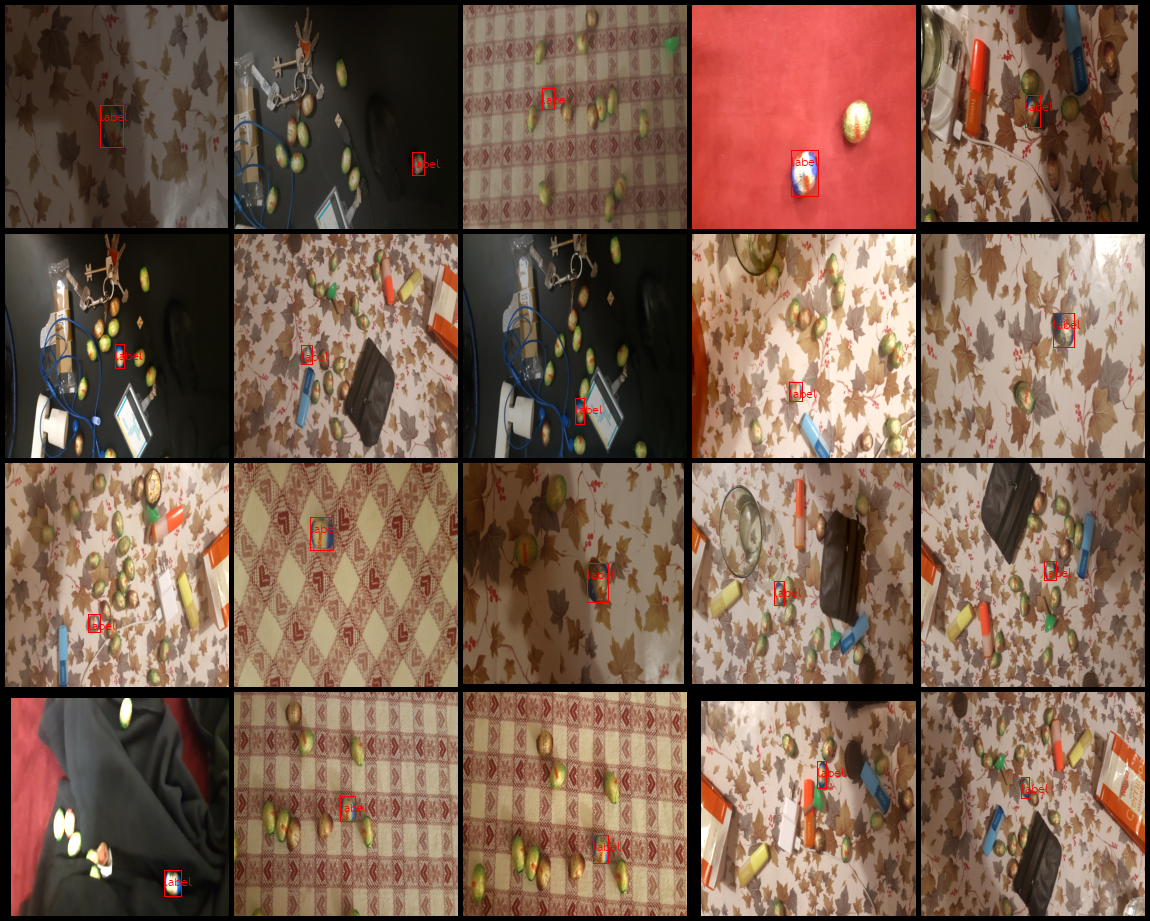

In [10]:
# Display results
grid =torchvision.utils.make_grid(torch.stack(imgs,dim=0), nrow=5, padding=5)
display(transforms.ToPILImage()(grid))

## Step 5) Design Object Detection Model

### Option 1) Pretrained Model (Resnet18)

In [12]:
def freeze_layers(model):
  # Freeze layers! we stop the layers from accumulating gradients
  # we do this for every params in the network
  # we do not wanto to do this for batch norm (bn)
  # We want this to be trained to approximate mean and std of the new dataset!
  for name, param in model.named_parameters():
    if ("bn" not in name):
      param.requires_grad = False # stop gradient prograpagation
    #else: 
    #  print(name)
  return model

def alexnet_modify(pretrained,num_classes):
  # get model
  alexnet = torchvision.models.alexnet(pretrained=pretrained)
  # copy network
  net = copy.deepcopy(alexnet)
  if pretrained:
    freeze_layers(net)
  #summary(net, (3, 224, 224), device="cpu")
  # Freeze layer (prevent updating gradient)
  # Modify last layer
  #print(f"Before {net.classifier}")
  net.classifier[6] = nn.Linear(net.classifier[6].in_features,out_features=num_classes)
  #print(f"After {net.classifier}")
  return net

def vgg16_modify(pretrained,num_classes):
  vgg16 = torchvision.models.vgg16(pretrained=pretrained)
  # copy network
  net = copy.deepcopy(vgg16)
  if pretrained:
    freeze_layers(net)
  # print number of params
  #  display network summary
  #summary(net, (3, 224, 224), device="cpu")
  # Freeze layer (prevent updating gradient)
  # Modify last layer
  #print(f"Before {net.classifier}")
  net.classifier[6] = nn.Linear(net.classifier[3].in_features,out_features=num_classes)
  #print(f"After {net.classifier}")
  return net

def resnet18_modify(pretrained,num_classes):

    class FinalLayer(nn.Module):
        def __init__(self,in_features, out_features):
            super(FinalLayer, self).__init__()
            self.fc1 = nn.Linear(in_features,128)
            self.fc2 = nn.Linear(128,64)
            self.fc3 = nn.Linear(64,32)
            self.fc4 = nn.Linear(32,out_features)
        def forward(self, x):
            x = torch.relu( self.fc1(x) )
            x = torch.relu( self.fc2(x) )
            x = torch.relu( self.fc3(x) )
            x = self.fc4(x)  
            return x

    resnet18 = torchvision.models.resnet18(pretrained=pretrained)
    # copy network
    net = copy.deepcopy(resnet18)
    # Freeze layer (stop accumulating gradient)
    if pretrained:
        freeze_layers(net)
    # print children
    #print_children(net)
    # print number of params
    #print("N params: ", get_number_of_params(net))
    #  display network summary
    #summary(net, (3, 224, 224), device="cpu")
    # Modify last layer
    #print(f"Before {net.fc}")
    #net.fc = torch.nn.Linear(net.fc.in_features,out_features=num_classes)
    net.fc = FinalLayer(net.fc.in_features,out_features=num_classes)
    #print(f"After {net.fc}")
    return net

net = resnet18_modify(pretrained=True,num_classes=params_aug["num_outputs"])
#net = vgg16_modify(pretrained=True,num_classes=params_aug["num_outputs"])
#net = alexnet_modify(pretrained=True,num_classes=params_aug["num_outputs"])

W,H = params_aug["target_size"]
C = 3
dummy_img = torch.rand(1,3,W,H)
with torch.no_grad():
    dummy_out = net.forward(dummy_img)
    print(dummy_out.shape)   
#print(net) 


torch.Size([1, 4])


### Option 2) Custom Deep Residual network

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# To train both xc,yc,w,h,p we need to pass images with and without person
# https://discuss.pytorch.org/t/how-can-i-use-different-losses-to-update-different-branches-respectively-and-sum-grad-together-to-update-master-main-branch/21700/12
'''
mse = nn.MSELoss(reduction="sum")
bce = nn.BCELoss(reduction="sum")
loss_xc = mse(torch.tensor(3.4,requires_grad=True),torch.tensor(9.5,requires_grad=True))
loss_yc = mse(torch.tensor(3.2,requires_grad=True),torch.tensor(5.6,requires_grad=True))
loss_w = mse(torch.tensor(3.1,requires_grad=True),torch.tensor(2.3,requires_grad=True))
loss_h = mse(torch.tensor(3.4,requires_grad=True),torch.tensor(1.2,requires_grad=True))
loss_p = bce(torch.tensor(0.3,requires_grad=True),torch.tensor(1.0)) #[0-1]
print(loss_xc,loss_yc,loss_w,loss_h, loss_p)
loss = loss_xc + loss_yc + loss_w + loss_h + loss_p
loss.backward()
print(loss.item())
'''
class Net(nn.Module):
    
    def __init__(self,C_in, size, init_f, num_outputs ):
        super(Net,self).__init__()
        # size --> H_in , W_in
        # C_in, H_in, W_in, init_f, num_outputs = params #(3, 416, 416, 16, 2)
        H_in, W_in = size
        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(C_in+init_f,2*init_f, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(C_in+3*init_f,4*init_f, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(C_in+7*init_f,8*init_f, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(C_in+15*init_f,16*init_f, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16*init_f, num_outputs)

    def forward(self,x):
        # Block 1
        identity = F.avg_pool2d(x,kernel_size=4,stride=4)
        #print("1. Identity ",identity.shape)
        x = F.relu(self.conv1(x))
        #print("1. Conv+Relu ", x.shape)
        x = F.max_pool2d(x,kernel_size=2,stride=2)
        #print("1. MaxPool ",x.shape)
        x = torch.cat((x,identity),dim=1)
        #print("1. Stack ", x.shape)

        # Block 2
        identity = F.avg_pool2d(x,kernel_size=2,stride=2)
        #print("2. Identity ",identity.shape)
        x = F.relu(self.conv2(x))
        #print("2. Conv+Relu ", x.shape)
        x = F.max_pool2d(x,kernel_size=2,stride=2)
        #print("2. MaxPool ",x.shape)
        x = torch.cat((x,identity),dim=1)
        #print("2. Stack ", x.shape)

        # Block 3
        identity = F.avg_pool2d(x,kernel_size=2,stride=2)
        #print("3. Identity ",identity.shape)
        x = F.relu(self.conv3(x))
        #print("3. Conv+Relu ", x.shape)
        x = F.max_pool2d(x,kernel_size=2,stride=2)
        #print("3. MaxPool ",x.shape)
        x = torch.cat((x,identity),dim=1)
        #print("3. Stack ", x.shape)

        # Block 4
        identity = F.avg_pool2d(x,kernel_size=2,stride=2)
        #print("4. Identity ",identity.shape)
        x = F.relu(self.conv4(x))
        #print("4. Conv+Relu ", x.shape)
        x = F.max_pool2d(x,kernel_size=2,stride=2)
        #print("4. MaxPool ",x.shape)
        x = torch.cat((x,identity),dim=1)
        #print("4. Stack ", x.shape)

        # Block 5
        x = F.relu(self.conv5(x))
        #print("5. Conv+Relu ", x.shape)
        x = F.adaptive_avg_pool2d(x,output_size=1)
        #print("5. AvgPool ",x.shape)
        x = x.reshape(x.size(0),-1)
        #print("5. Reshape ", x.shape)
        x = self.fc1(x)
        #print("5 FC ",x.shape)
        return x

W,H = params_aug["target_size"]
C = 3
net = Net(C_in=C, size=(W,H), init_f=16, num_outputs=params_aug["num_outputs"]) # outputs xc,yc,w,h
dummy_img = torch.rand(1,3,W,H)
with torch.no_grad():
    dummy_out = net.forward(dummy_img)
    print(dummy_out.shape)   
print(net) 

torch.Size([1, 4])
Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(19, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(51, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(115, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(243, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=256, out_features=4, bias=True)
)


## Step 6) Training

In [ ]:
from torch import optim
from torchsummary import summary
import copy
import plotly.graph_objects as go
from torch import nn 


def metrics_func_object_detection(target,output):
    # Nx4 
    # target and ouput are normalized --> 0-1
    # target = output =  (xc,yc, w, h)
    xytl = output[:, :2] - output[:, 2:]/2 # top left
    xybr = output[:, :2] + output[:, 2:]/2 # bottom right
    output = torch.cat( (xytl,xybr), 1)

    xytl = target[:, :2] - target[:, 2:]/2 # top left
    xybr = target[:, :2] + target[:, 2:]/2 # bottom right
    target = torch.cat( (xytl,xybr), 1)

    iou=torchvision.ops.box_iou(output, target)
    return torch.diagonal(iou, 0).sum().item()

# validation metric classification
def metrics_func_classification(target, output):
    # Compute number of correct prediction
    pred = output.argmax(dim=-1,keepdim=True)
    corrects =pred.eq(target.reshape(pred.shape)).sum().item()
    return -corrects # minus for coeherence with best result is the most negative one

# validation: metric regression
def metrics_func_regression(target, output):
    # Comptue mean squaer error (Migliora quanto piu' ci avviciniamo a zero)
    mse = torch.sum((output - target) ** 2)
    return mse

# training: loss calculation and backward step
def loss_batch(loss_func,metric_func, xb,yb,yb_h, opt=None):
    # obtain loss
    loss = loss_func(yb_h, yb)
    # obtain performance metric 
    with torch.no_grad():
        metric_b = metric_func(yb,yb_h)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), metric_b

# one epoch training
def loss_epoch(model, loss_func,metric_func, dataset_dl, sanity_check,opt, device):
    loss = 0.0
    metric = 0.0
    len_data = float(len(dataset_dl.dataset))
    # get batch data
    for xb,yb in dataset_dl:    
        # send to cuda the data (batch size)
        xb = xb.to(device)
        yb = yb.to(device)
        # obtain model output 
        yb_h = model.forward(xb)
        # loss and metric Calculation
        loss_b, metric_b = loss_batch(loss_func,metric_func, xb,yb,yb_h,opt)
        # update loss
        loss += loss_b
        # update metric
        if metric_b is not None:
            metric+=metric_b 
        if sanity_check is True:
            break
    # average loss
    loss /=len_data
    # average metric
    metric /=len_data
    return loss, metric

# get learning rate from optimizer
def get_lr(opt):
    # opt.param_groups[0]['lr']
    for param_group in opt.param_groups:
        return param_group["lr"]

# trainig - test loop
def train_test(params):
    # --> extract params
    model = params["model"]
    loss_func=params["loss_func"]
    metric_func=params["metric_func"]
    num_epochs=params["num_epochs"]
    opt=params["optimizer"]
    lr_scheduler=params["lr_scheduler"]
    train_dl=params["train_dl"]
    test_dl=params["test_dl"]
    device=params["device"]
    continue_training=params["continue_training"]
    sanity_check=params["sanity_check"]
    path2weigths=params["path2weigths"]
    # --> send model to device and print device
    model = model.to(device)
    print("--> training device %s" % (device))
    # --> if continue_training=True load path2weigths
    if continue_training==True and os.path.isfile(path2weigths):
        print("--> continue training  from last best weights")
        weights = torch.load(path2weigths)
        model.load_state_dict(weights)
    # --> history of loss values in each epoch
    loss_history={"train": [],"test":[]}
    # --> history of metric values in each epoch
    metric_history={"train": [],"test":[]}
    # --> a deep copy of weights for the best performing model
    best_model_weights = copy.deepcopy(model.state_dict())
    # --> initialiaze best loss to large value
    best_loss=float("inf")
    # --> main loop
    for epoch in range(num_epochs):
        # --> get learning rate
        lr = get_lr(opt)
        print("----\nEpoch %s/%s, lr=%.6f" % (epoch+1,num_epochs,lr))
        # --> train model on training dataset
        # we tell to the model to enter in train state. it is important because
        # there are somelayers like dropout, batchnorm that behaves 
        # differently between train and test
        model.train()
        train_loss,train_metric = loss_epoch(model, loss_func, metric_func,train_dl,sanity_check, opt,device)
        # --> collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        # --> tell the model to be in test (validation) mode
        model.eval()
        with torch.no_grad():
            test_loss, test_metric = loss_epoch(model, loss_func, metric_func, test_dl,sanity_check,opt=None,device=device)
        # --> collect loss and metric for test dataset
        loss_history["test"].append(test_loss)
        metric_history["test"].append(test_metric)
        # --> store best model
        if test_loss < best_loss:
            print("--> model improved! --> saved to %s" %(path2weigths))
            best_loss = test_loss
            best_model_weights = copy.deepcopy(model.state_dict())
            # --> store weights into local file
            torch.save(model.state_dict(),path2weigths)
        # --> learning rate scheduler
        lr_scheduler.step()
        print("--> train_loss: %.6f, test_loss: %.6f, train_metric: %.3f, test_metric: %.3f" % (train_loss,test_loss,train_metric,test_metric))
    # --> load best weights
    model.load_state_dict(best_model_weights)
    return model, loss_history,metric_history

# Setup GPU Device
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda:0")
opt = optim.Adam(net.parameters(),lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.999)  #  lr = lr * gamma ** last_epoch
params = {
    "model":                 net,
    "loss_func":             nn.SmoothL1Loss(reduction="sum"), # nn.MSELoss(reduction="sum") 
    "metric_func":           metrics_func_object_detection,
    "num_epochs":            1000,
    "optimizer":             opt,
    "lr_scheduler":          lr_scheduler,
    "train_dl":              train_dl,
    "test_dl":               test_dl,
    "device":                device,  
    "continue_training" :    False,  # continue training from last save weights
    "sanity_check":          False, # if true we only do one batch per epoch
    "path2weigths":          "./best_model.pt"  
} 
model, loss_history,metric_history = train_test(params)     

In [ ]:
# Comparison train and test set
device = torch.device("cpu")
net = net.to(device)
net.eval()
imgs = []
for x,y in test_dl: # test_dl
    for im,l in zip(x,y):
        with torch.no_grad():
            l_est = net.forward(im.unsqueeze(0))[0]
            res = compare_img_bbox(im,l, l_est)
            imgs.append( transforms.ToTensor()( res ) )
grid =torchvision.utils.make_grid(torch.stack(imgs,dim=0), nrow=5, padding=5)
display(transforms.ToPILImage()(grid))    

## Step 7) Test

 ### Test Trained Model on train test images

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# Load Model
device = torch.device("cpu")
W,H = (224,224)
num_outputs = 4
#net = Net(C_in=3, size=(W,H), init_f=16, num_outputs=num_outputs) # outputs xc,yc,w,h
net = resnet18_modify(pretrained=False,num_classes=num_outputs)
#net = vgg16_modify(pretrained=False,num_classes=num_outputs)
#net = alexnet_modify(pretrained=False,num_classes=num_outputs)
path2weights = "best_model.pt"
weights = torch.load(path2weights)
net.load_state_dict(weights)
net.eval()
#path = "dataset/train"
path = "dataset/test"
names = os.listdir(path)
for name in names:
    filename = os.path.join(path,name)
    frame = cv2.imread(filename,1)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    im_pil = transforms.ToPILImage()(frame).resize((W,H))
    im_tensor = transforms.ToTensor()( im_pil ).unsqueeze(0) # scale 0-1
    with torch.no_grad():
        y_hat = net.forward(im_tensor)
        res = get_img_bbox(im_tensor[0],y_hat[0])
        display(res)

### Covert Model to onnx format

In [17]:
import torch
# https://michhar.github.io/convert-pytorch-onnx/
W,H = (224,224)
num_outputs = 4
#net = Net(C_in=3, size=(W,H), init_f=16, num_outputs=num_outputs) # outputs xc,yc,w,h
net = resnet18_modify(pretrained=False,num_classes=num_outputs)
#net = vgg16_modify(pretrained=False,num_classes=num_outputs)
#net = alexnet_modify(pretrained=False,num_classes=num_outputs)
net = resnet18_modify(pretrained=False,num_classes=4)

path2weights = "best_model.pt"
weights = torch.load(path2weights)
net.load_state_dict(weights)

dummy_input = torch.randn(1, C, H, W)
torch.onnx.export(net, dummy_input, "best_model.onnx")

### Test Onnx Created Model

In [ ]:
!pip install onnxruntime

In [ ]:
import onnxruntime as rt
import numpy as np
import cv2

def apply(im,mi):
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  iW = im.shape[1]
  iH = im.shape[0]
  #print(w,h)
  x = cv2.resize(im, (224,224))
  x = x.astype(np.float32)/255.0
  x = np.transpose(x, (2, 0, 1) ) # BCHW
  x = x[np.newaxis,:,:,:]
  res = mi.predict(x)
  xc,yc,w,h = tuple(res[0][0])
  xcPix,ycPix,wPix,hPix =  ( xc*iW, yc*iH, w*iW, h*iH ) 
  xtl = xcPix - wPix/2
  ytl = ycPix - hPix/2
  xbr = xcPix + wPix/2
  ybr = ycPix + hPix/2
  im = cv2.rectangle(im,(int(xtl),int(ytl)),(int(xbr),int(ybr)),(0,255,0),2)
  return im

class modelInference:

  def __init__(self,path2model):
    self.sess = rt.InferenceSession(path2model)
    self.input_name = self.sess.get_inputs()[0].name
    self.input_shape = self.sess.get_inputs()[0].shape
    self.input_type = self.sess.get_inputs()[0].type
    self.output_name = self.sess.get_outputs()[0].name
    self.output_shape = self.sess.get_outputs()[0].shape
    self.output_type = self.sess.get_outputs()[0].type

  def print_model_info(self):
    # Input informations
    print("input name", self.input_name)
    print("input shape", self.input_shape)
    print("input type", self.input_type)
    # Outpout informations
    print("output name", self.output_name)
    print("output shape", self.output_shape)
    print("output type", self.output_type)

  def predict(self, x):
    x = x.astype(np.float32)
    res = self.sess.run([self.output_name], {self.input_name: x})
    return res

path2model = "best_model.onnx"
mi = modelInference(path2model)
mi.print_model_info()
#x = np.random.random((1,3,224,224))
#res = mi.predict(x)

#frame = cv2.imread("dataset/train/20210407_223624.png",1)
#frame = cv2.imread("dataset/train/20210407_223706.png",1)
frame = cv2.imread("photo.jpg",1)

res = apply(frame,mi)
im_pil = transforms.ToPILImage()(res) 
w,h = im_pil.size
display( im_pil.resize((w//2,h//2)) )


In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

cap = cv2.VideoCapture("test.mp4")
while (cap.isOpened()):
    ret, frame = cap.read()
    if ret:
        # Frame 
        res = apply(frame, mi)
        im_pil = transforms.ToPILImage()(res) 
        w,h = im_pil.size
        display( im_pil.resize((w//2,h//2)) )
    else:
        break
cap.release()

